# Title:  Telecom Churn Predication

# 1. Libraries and Modules

In [1]:
#Install Libraries and import modules
#All installs and imports are done here to keep them all together
#As more are needed further down the cells, they will be added here

#The installs have been commened out, because in my run I have already installed them and do not need to run
#them over and over

#!pip install plotly
#!pip install seaborn
#!pip install openpyxl -q

#All the below imports will be run at the start of each complete run or will need to be rerun if anything new
#is added to the list.

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import math
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# 2. EDA

**2.1 Snapshot of the Test Data**

Using the train.csv file, we are able to see a snapshot of sample, where we can also see the churn rate.

In [2]:
df = pd.read_csv('Train.csv')               #path to Training Data File

total_customers = len(df)
retained_customers = len(df[df['CHURN'] == 0])
churned_customers = len(df[df['CHURN'] == 1])
churn_rate = churned_customers / total_customers * 100

retained_customers1 = len(df[df['CHURN'] == 0])

fig = go.Figure()

# Total Customers
fig.add_trace(go.Indicator(
    mode="number",
    value=total_customers,
    title="Total Customers",
    number={'font': {'size': 32}},
    domain={'x': [0, 0.1], 'y': [0, 1]}
))

# Retained Customers
fig.add_trace(go.Indicator(
    mode="number",
    value=retained_customers,
    title="Retained Customers",
    number={'font': {'size': 32}},
    domain={'x': [0.25, 0.45], 'y': [0, 1]}
))

# Churned Customers
fig.add_trace(go.Indicator(
    mode="number",
    value=churned_customers,
    title="Churned Customers",
    number={'font': {'size': 32}},
    domain={'x': [0.55, 0.75], 'y': [0, 1]}
))

# Churn Rate
fig.add_trace(go.Indicator(
    mode="number",
    value=churn_rate,
    title="Churn Rate",
    number={'font': {'size': 28}, 'suffix': '%'},
    delta={'reference': 0, 'relative': False, 'position': "bottom"},
    domain={'x': [0.9, 0.95], 'y': [0, 1]}
))

fig.update_layout(width=1000, height=100, margin=dict(t=50, b=50, l=10, r=10))
fig.show()

From the sample, we can see that the churning rate is 18.75%.

**2.2 The columns of the data.**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


From above information, based on the readings of relative materials, we define each field as following.

* user_id: unique customer identifier
* REGION: customer location
* TENURE: duraton being a customer of Expresso
* MONTANT: the amount of money the user has paid to the company
* FREQUENCE_RECH: number of times the customer recharges their phone account
* REVENUE: montly income generated from the customer
* ARPU_SEGMENT: average revenue per user segment / income over 90 days/3
* FREQUENCE: number of times the customer has made an income
* DATA_VOLUME: the amount of data used by the customer
* ON_NET: inter Expresso calls made by the user
* ORANGE: calls to Orange network
* TIGO: calls to Tigo network
* ZONE1: calls to ZONE1 network
* ZONE2: calls to ZONE2 network
* MRG: the merger status / A client who is going
* REGULARITY: number of month the customer is active for 90 days
* TOP_PACK: the most active packs
* FREQ_TOP_PACK: number of times of activating the top service package
* CHURN: churned or not (1 if the user has churned, 0 otherwise)

We also noticed that several fields are **object type**.

In [4]:
df.shape

(2154048, 19)

In [5]:
df.head()
churned_df = df[df['CHURN'] == 1]
print(churned_df.head())

                                     user_id REGION         TENURE  MONTANT  \
1   00000cb4a5d760de88fecb38e2f71b7bec52e834    NaN  I 18-21 month      NaN   
12  000068fe2aad763fb2667d253fa4c9e19e3b0636    NaN  G 12-15 month      NaN   
17  0000a45ed15492427df603217166f1f813a2cc83    NaN  H 15-18 month      NaN   
21  0000b00bed6ad90fd35d1957f484f9e54990c714    NaN  I 18-21 month      NaN   
22  0000b4af921db374095a9e7ab87ee314522e4fe4    NaN   K > 24 month      NaN   

    FREQUENCE_RECH  REVENUE  ARPU_SEGMENT  FREQUENCE  DATA_VOLUME  ON_NET  \
1              NaN      NaN           NaN        NaN          NaN     NaN   
12             NaN      NaN           NaN        NaN          NaN     NaN   
17             NaN      NaN           NaN        NaN          NaN     NaN   
21             NaN      NaN           NaN        NaN          0.0     NaN   
22             NaN      NaN           NaN        NaN          NaN     NaN   

    ORANGE  TIGO  ZONE1  ZONE2 MRG  REGULARITY TOP_PACK  FREQ_

From above, we can quickly review the values of each column. W**e found that some lines have NaN values.**
To get general information, we can also use df.describe(). W**e noticed that both TOP_PACK and TENURE are texts which should encoded to digits before we train our model.**

In [6]:
df.describe()

MONTANT  FREQUENCE_RECH       REVENUE  ARPU_SEGMENT     FREQUENCE  \
count  1.397309e+06    1.397309e+06  1.428000e+06  1.428000e+06  1.428000e+06   
mean   5.532117e+03    1.152912e+01  5.510810e+03  1.836943e+03  1.397814e+01   
std    7.111339e+03    1.327407e+01  7.187113e+03  2.395700e+03  1.469403e+01   
min    1.000000e+01    1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
25%    1.000000e+03    2.000000e+00  1.000000e+03  3.330000e+02  3.000000e+00   
50%    3.000000e+03    7.000000e+00  3.000000e+03  1.000000e+03  9.000000e+00   
75%    7.350000e+03    1.600000e+01  7.368000e+03  2.456000e+03  2.000000e+01   
max    4.700000e+05    1.330000e+02  5.321770e+05  1.773920e+05  9.100000e+01   

        DATA_VOLUME        ON_NET        ORANGE           TIGO          ZONE1  \
count  1.093615e+06  1.367373e+06  1.258800e+06  864032.000000  169721.000000   
mean   3.366450e+03  2.776891e+02  9.541871e+01      23.109253       8.170132   
std    1.330446e+04  8.726889e+02  2.049873e+02      63.578086      41.169511   
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    0.000000e+00  5.000000e+00  7.000000e+00       2.000000       0.000000   
50%    2.570000e+02  2.700000e+01  2.900000e+01       6.000000       1.000000   
75%    2.895000e+03  1.560000e+02  9.900000e+01      20.000000       3.000000   
max    1.823866e+06  5.080900e+04  2.132300e+04    4174.000000    4792.000000   

               ZONE2    REGULARITY  FREQ_TOP_PACK         CHURN  
count  136824.000000  2.154048e+06   1.251454e+06  2.154048e+06  
mean        7.553309  2.804251e+01   9.272461e+00  1.875474e-01  
std        33.487234  2.228686e+01   1.228044e+01  3.903504e-01  
min         0.000000  1.000000e+00   1.000000e+00  0.000000e+00  
25%         0.000000  6.000000e+00   2.000000e+00  0.000000e+00  
50%         2.000000  2.400000e+01   5.000000e+00  0.000000e+00  
75%         5.000000  5.100000e+01   1.200000e+01  0.000000e+00  
max      3697.000000  6.200000e+01   7.130000e+02  1.000000e+00

In [7]:
sum_cols = df.isnull().sum()

clients = len(df)
Cols_per = 100 - (sum_cols / clients)*100

print("Total percentage of data in column")
print(Cols_per)

Total percentage of data in column
user_id           100.000000
REGION             60.571956
TENURE            100.000000
MONTANT            64.868982
FREQUENCE_RECH     64.868982
REVENUE            66.293787
ARPU_SEGMENT       66.293787
FREQUENCE          66.293787
DATA_VOLUME        50.770224
ON_NET             63.479226
ORANGE             58.438809
TIGO               40.112012
ZONE1               7.879165
ZONE2               6.351948
MRG               100.000000
REGULARITY        100.000000
TOP_PACK           58.097777
FREQ_TOP_PACK      58.097777
CHURN             100.000000
dtype: float64


**2.3 Feature Fields Correlation Analysis**

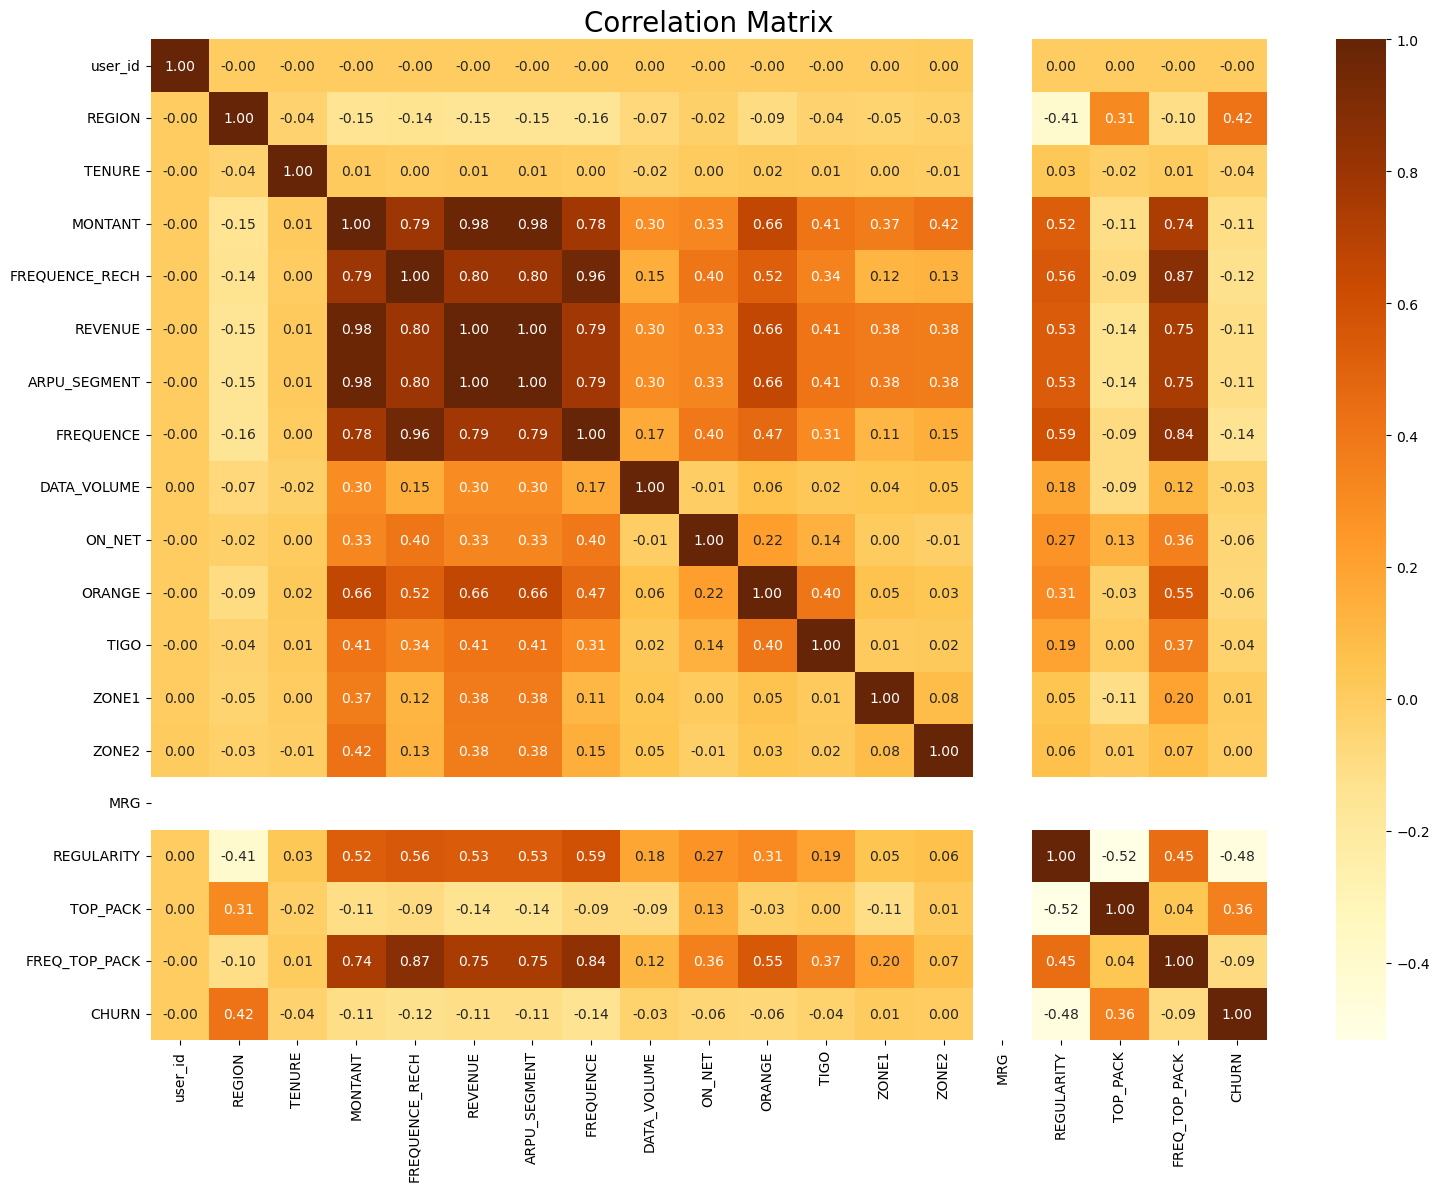

In [8]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

num_cols = df.select_dtypes(include=[np.number]).columns

corr = df.corr()

# Correlation Matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="YlOrBr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

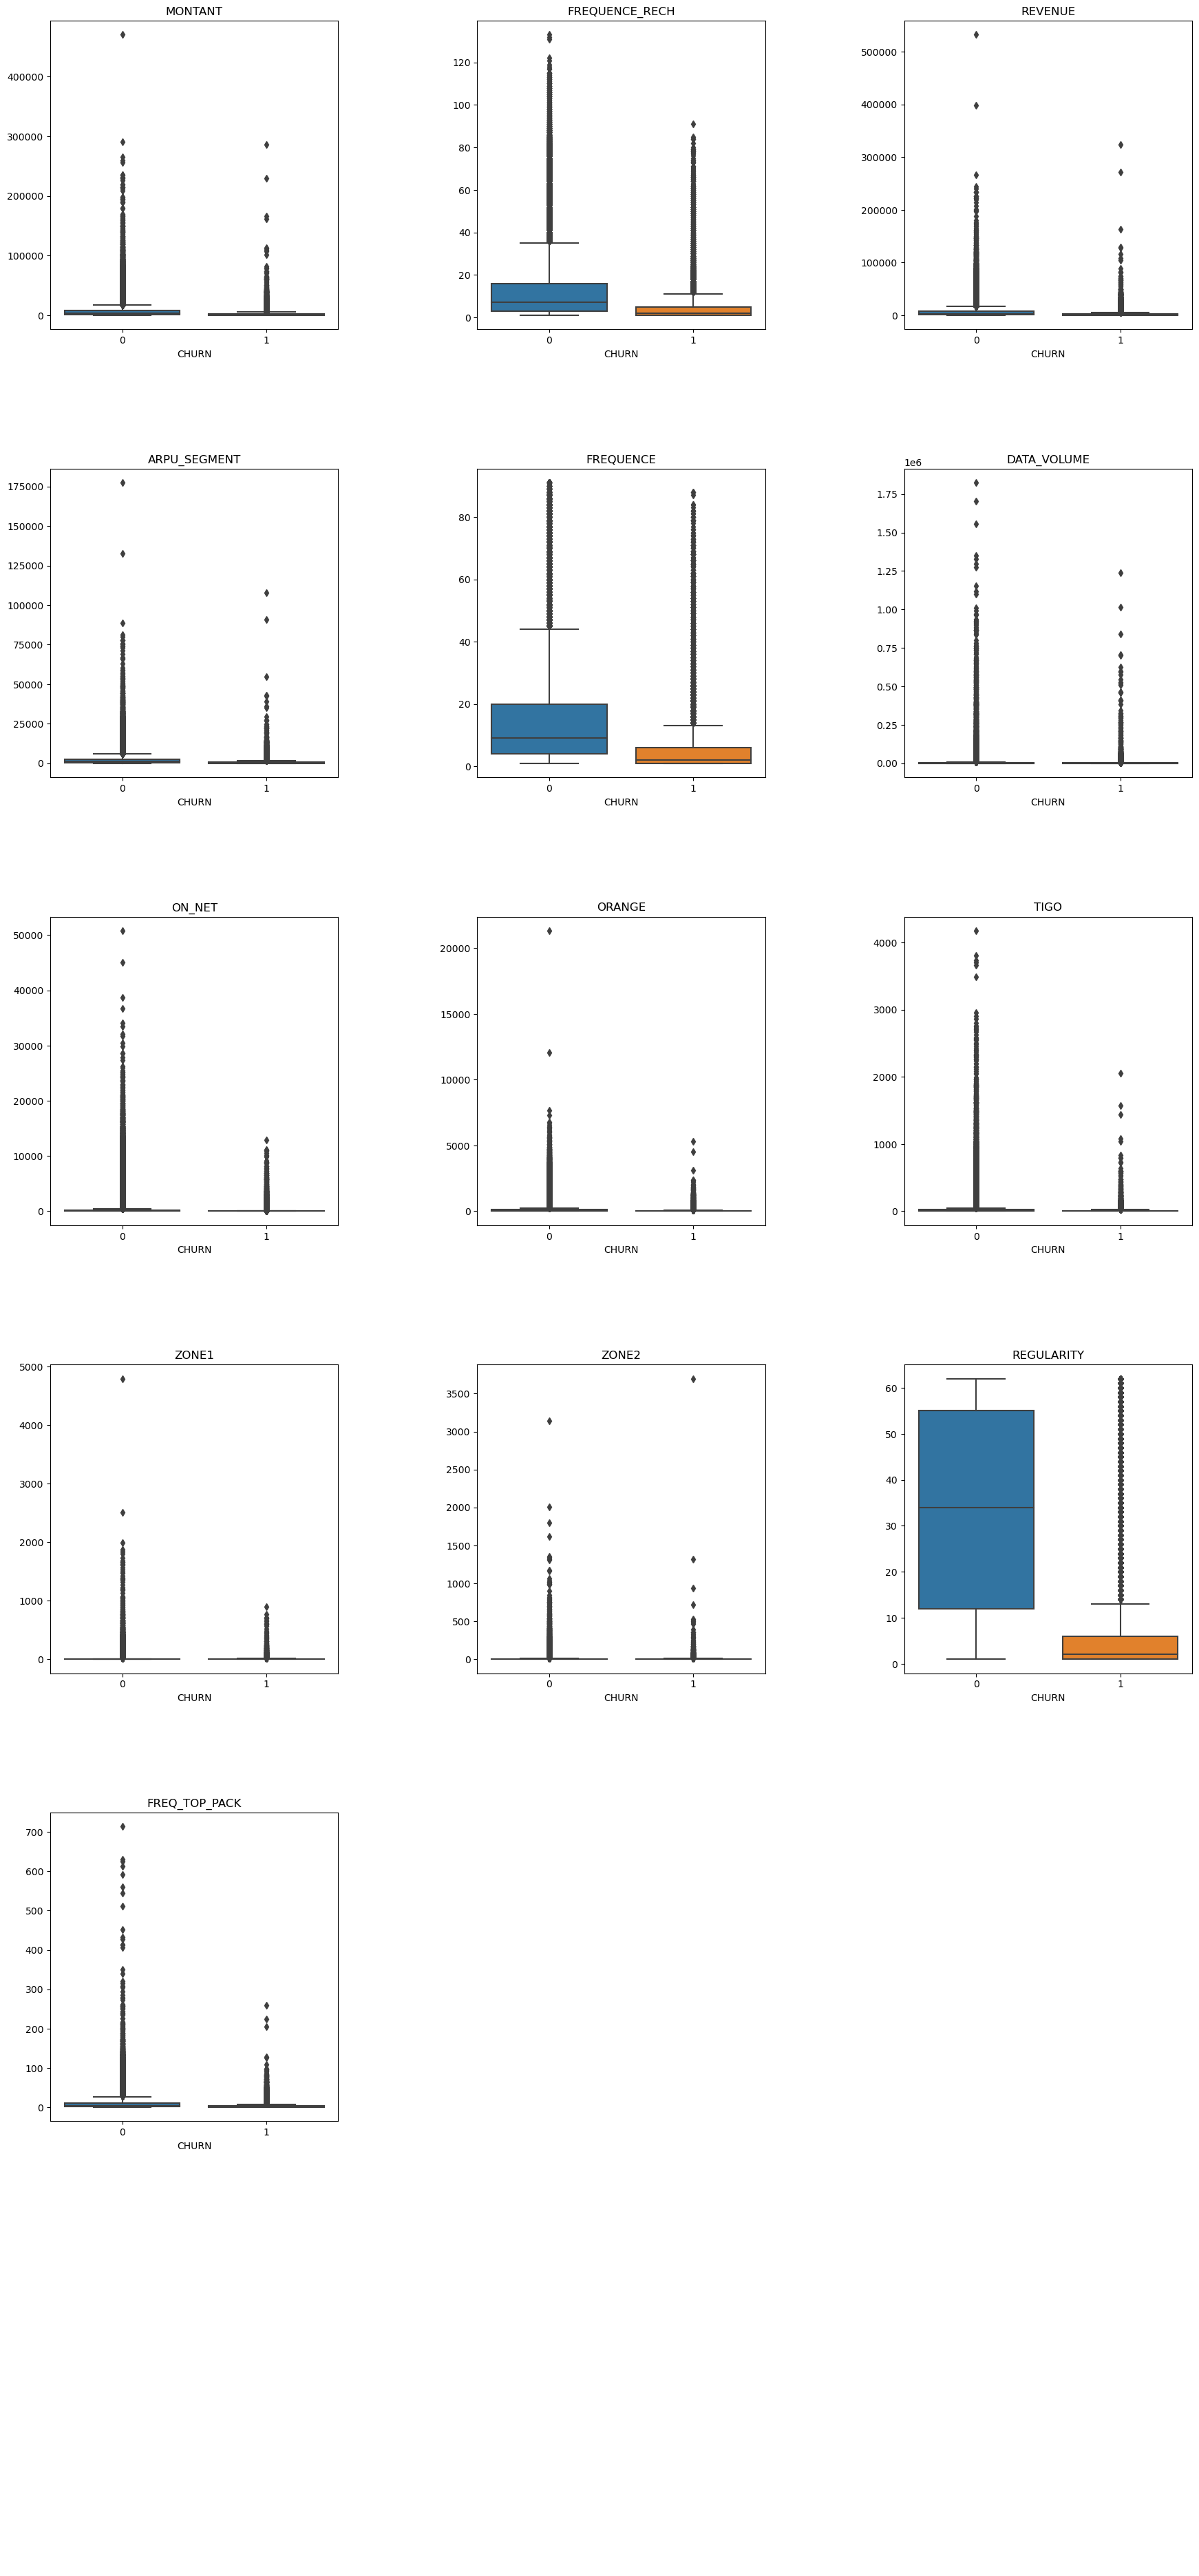

In [9]:
num_cols_filtered = [col for col in num_cols if col not in cat_cols and col != 'CHURN']

num_plots = len(num_cols_filtered)
num_rows = math.ceil(num_plots / 4)

fig, ax = plt.subplots(6, 3, figsize=(20, 40))
ax = ax.flatten()

for idx, c in enumerate(num_cols_filtered):
    dff = df[df[c].notnull()].copy()
    ax[idx].set_title(c)
    sns.boxplot(x='CHURN', y=c, data=dff, ax=ax[idx])
    ax[idx].set_ylabel('')

for i in range(len(num_cols_filtered), len(ax)):
    ax[i].axis('off')

plt.tight_layout(pad=10, w_pad=10, h_pad=10)
plt.show()

We are going to focus on **several important features with high variances**.

# 3. Deep Data Analysis

**3.1 Selected Features vs Target**

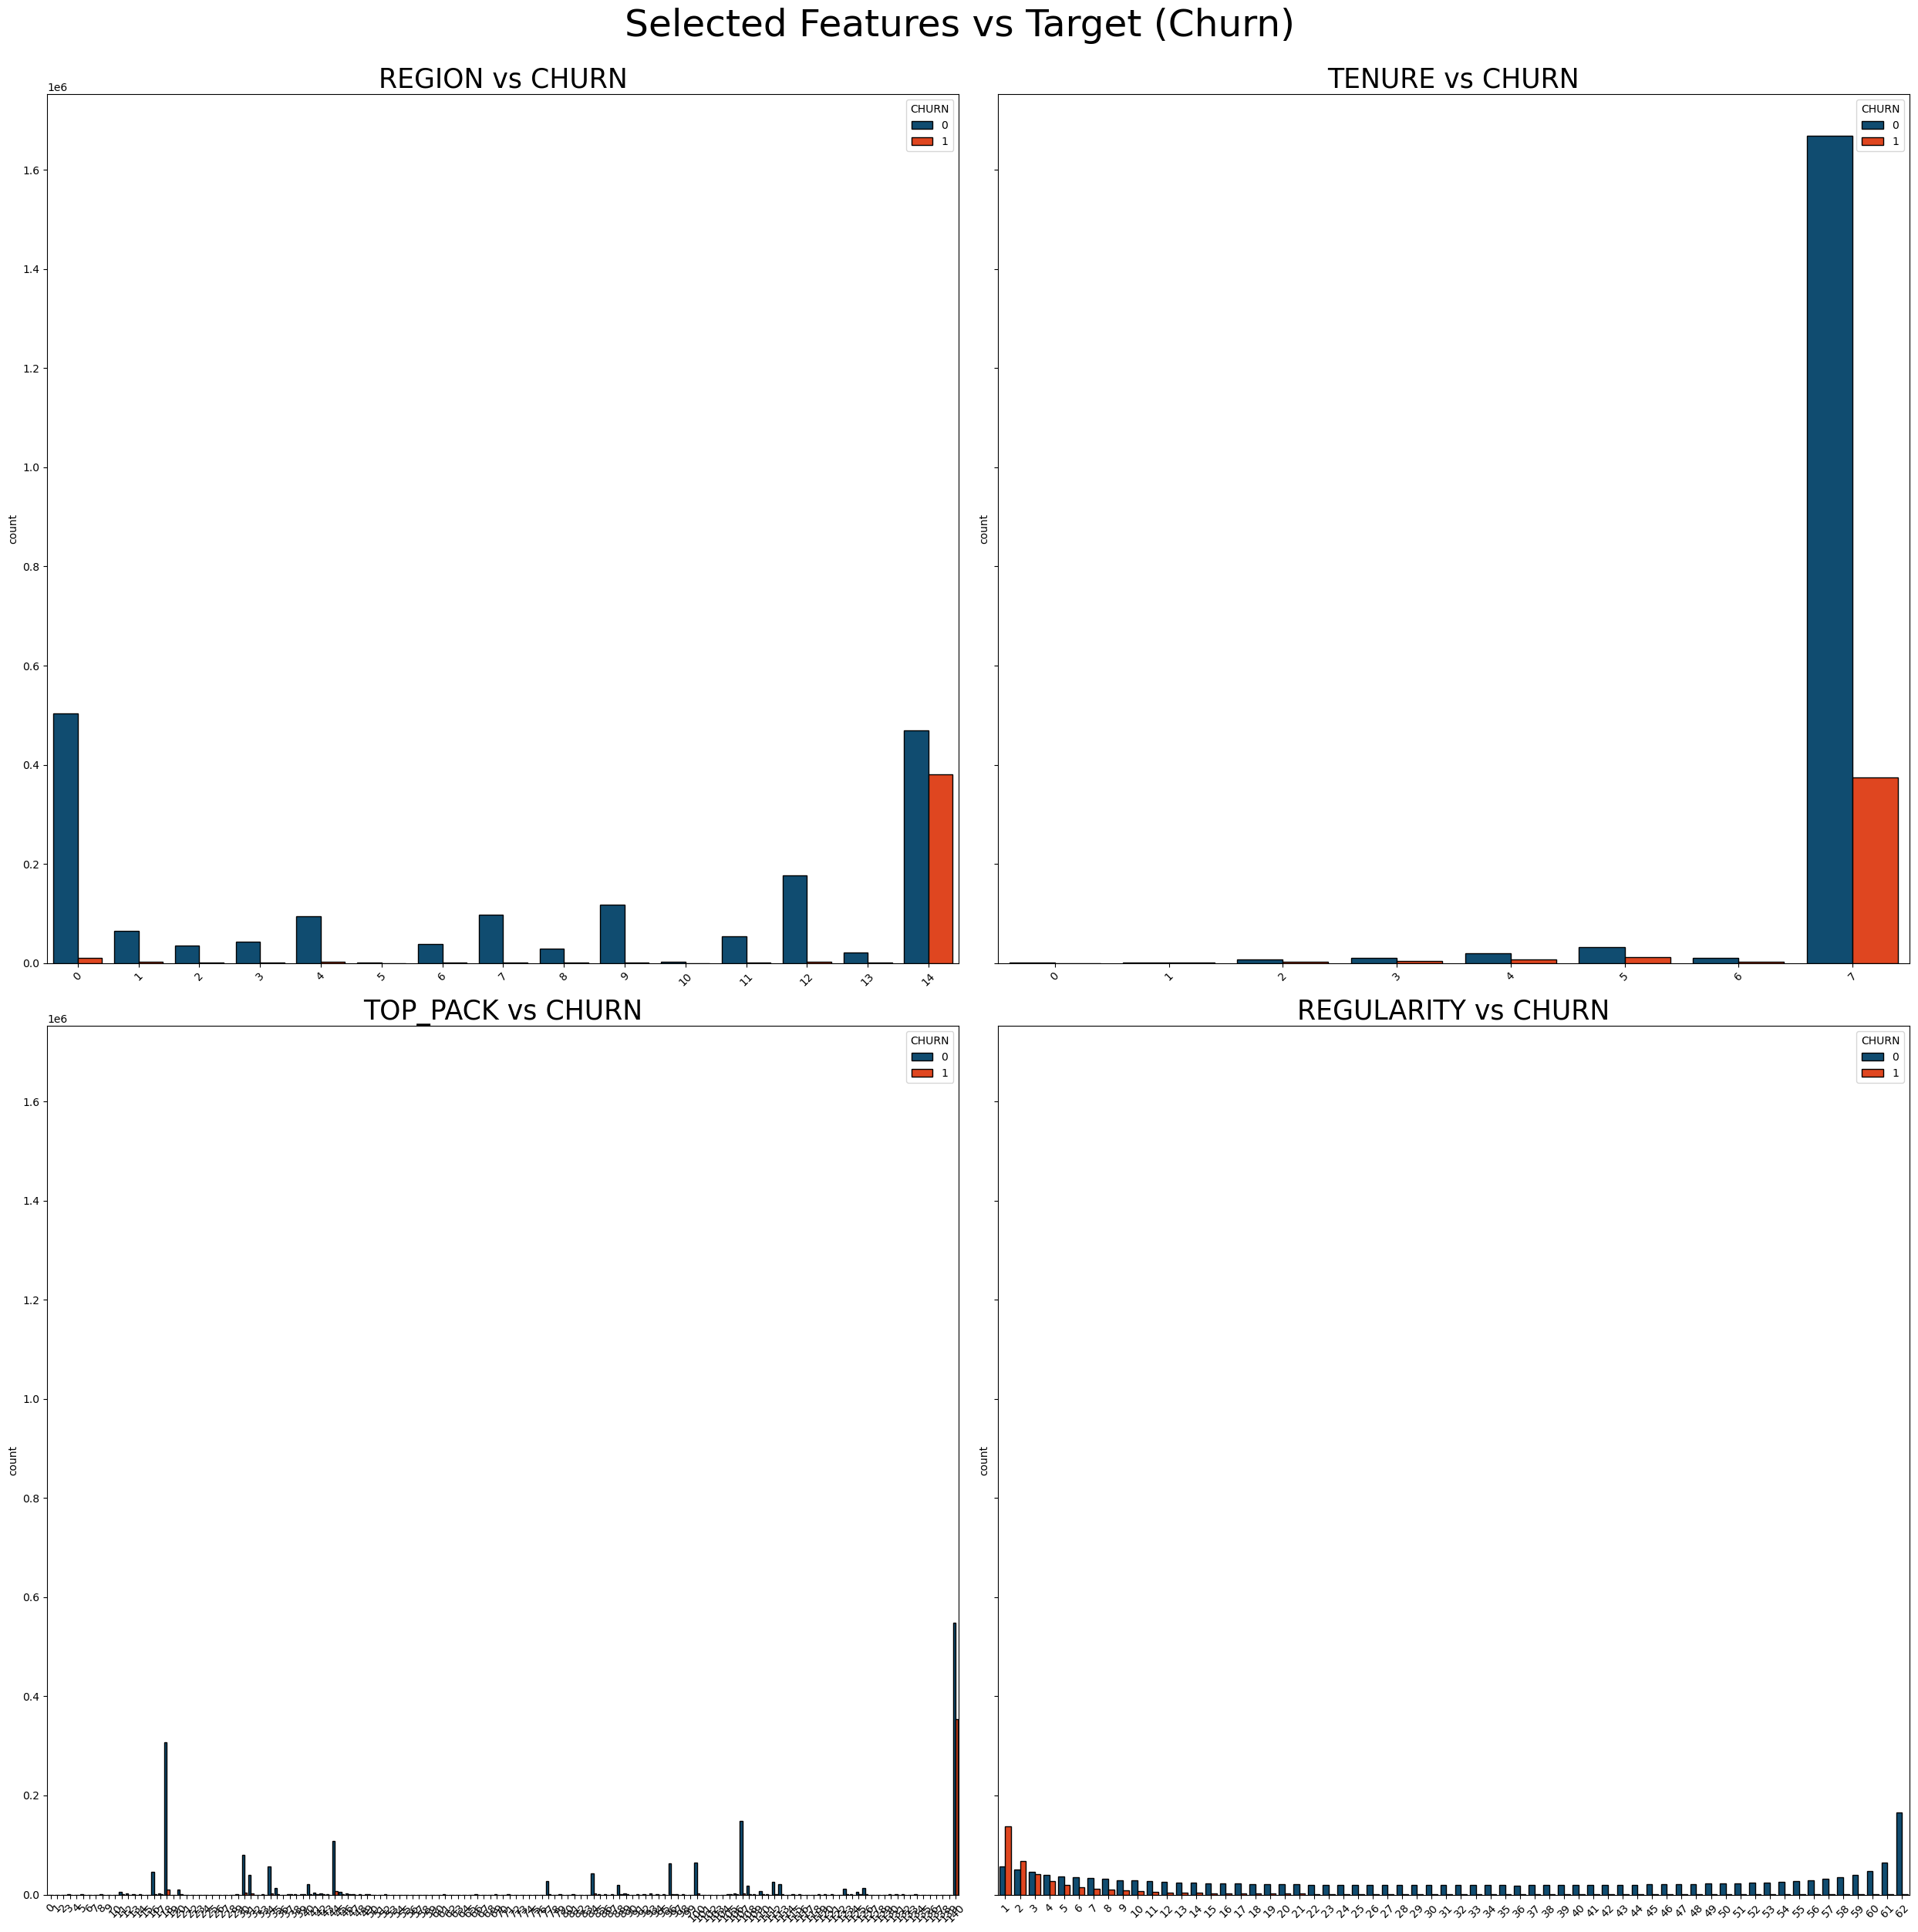

In [10]:
def countplots_custom(dataset, columns_list, rows, cols, figsize, suptitle, hue, palette):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    fig.suptitle(suptitle, y=1, size=35)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        ax = sns.countplot(data=dataset, ax=axs[i], x=columns_list[i], hue=hue, palette=palette, edgecolor='black')
        axs[i].set_title(data + f' vs {hue}', size=25)
        ax.set_xlabel('')
        axs[i].tick_params(axis='x', rotation=45)

hue = "CHURN"
palette = ['#005080', '#FF3300']

list3 = ['REGION', 'TENURE', 'TOP_PACK', 'REGULARITY']

countplots_custom(dataset=df, columns_list=list3, rows=2, cols=2, figsize=(25, 25), hue=hue, palette=palette, suptitle='Selected Features vs Target (Churn)')
plt.tight_layout()

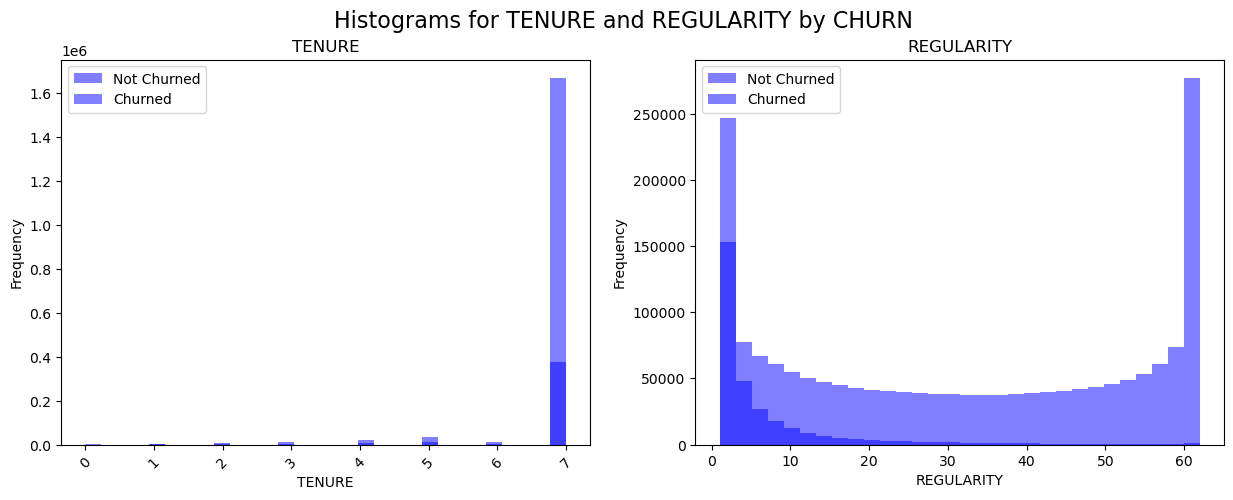

In [11]:
fig1 = px.histogram(df, x="TENURE", color="CHURN", barmode="group")
fig1.update_traces(textposition='auto', hovertemplate='%{x}<br>%{y}')

fig2 = px.histogram(df, x="REGULARITY", color="CHURN", barmode="group")
fig2.update_traces(textposition='auto', hovertemplate='%{x}<br>%{y}')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('TENURE')
axs[1].set_title('REGULARITY')
fig.suptitle('Histograms for TENURE and REGULARITY by CHURN', fontsize=16)

for trace in fig1['data']:
    if trace['name'] == 'True':
        axs[0].hist(trace['x'], bins=30, alpha=0.5, color='r')
    else:
        axs[0].hist(trace['x'], bins=30, alpha=0.5, color='b')
    axs[0].legend(['Not Churned', 'Churned'])
    axs[0].set_xlabel('TENURE')
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_ylabel('Frequency')

# Plot the second histogram
for trace in fig2['data']:
    if trace['name'] == 'True':
        axs[1].hist(trace['x'], bins=30, alpha=0.5, color='r')
    else:
        axs[1].hist(trace['x'], bins=30, alpha=0.5, color='b')
    axs[1].legend(['Not Churned', 'Churned'])
    axs[1].set_xlabel('REGULARITY')
    axs[1].set_ylabel('Frequency')

plt.show()


**3.2 ABC Analysis for Top Factors**

In [12]:
columns_list = ['REGION', 'TENURE', 'TOP_PACK', 'REGULARITY']
top_churned = []

le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

for column in columns_list:
    churned_data = df[df['CHURN'] == 1]
    top_3_churned = churned_data[column].value_counts().head(3)
    total_churned = churned_data[column].value_counts().sum()

    for value, count in top_3_churned.items():
        if column in le_dict:  # Check if the column was encoded
            text_value = le_dict[column].inverse_transform([value])[0]  # Get the actual text value
        else:
            text_value = value

        percentage = (count / total_churned) * 100
        top_churned.append([column, text_value, count, f"{percentage:.2f}%"])

headers = ['Column Name', 'Value', 'Count', 'Percentage']
print(tabulate(top_churned, headers=headers, tablefmt='pretty'))


+-------------+-------+--------+------------+
| Column Name | Value | Count  | Percentage |
+-------------+-------+--------+------------+
|   REGION    |  14   | 380475 |   94.18%   |
|   REGION    |   0   |  9873  |   2.44%    |
|   REGION    |  12   |  2935  |   0.73%    |
|   TENURE    |   7   | 374389 |   92.67%   |
|   TENURE    |   5   | 12347  |   3.06%    |
|   TENURE    |   4   |  6924  |   1.71%    |
|  TOP_PACK   |  140  | 353726 |   87.56%   |
|  TOP_PACK   |  18   | 10280  |   2.54%    |
|  TOP_PACK   |  44   |  7279  |   1.80%    |
| REGULARITY  |   1   | 137955 |   34.15%   |
| REGULARITY  |   2   | 68415  |   16.93%   |
| REGULARITY  |   3   | 40822  |   10.10%   |
+-------------+-------+--------+------------+


From the above chart, we can see that most people are (94.18%) are those K > 24 months. Region 14 is the labelencoded version of K > 24 months.

**3.3 User Profiles**

* REGION: customer location
* TENURE: duraton being a customer of Expresso

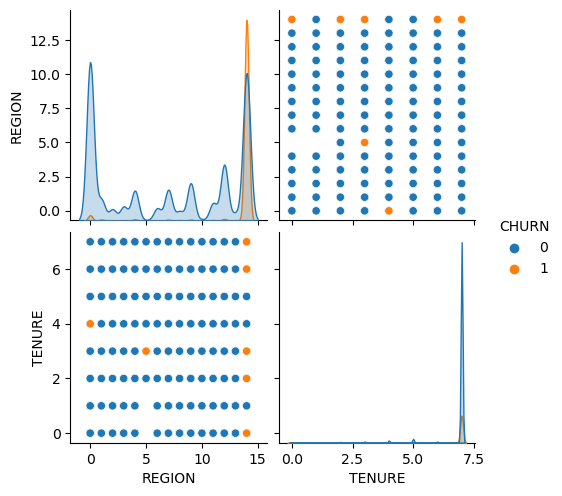

In [13]:
sns.pairplot(data=df[['REGION', 'TENURE', 'CHURN']], diag_kind='kde', hue='CHURN')
plt.show()

**3.4 User Payments**

* MONTANT: the amount of money the user has paid to the company
* FREQUENCE_RECH: number of times the customer recharges their phone account
* REVENUE: montly income generated from the customer
* ARPU_SEGMENT: average revenue per user segment / income over 90 days/3
* FREQUENCE: number of times the customer has made an income

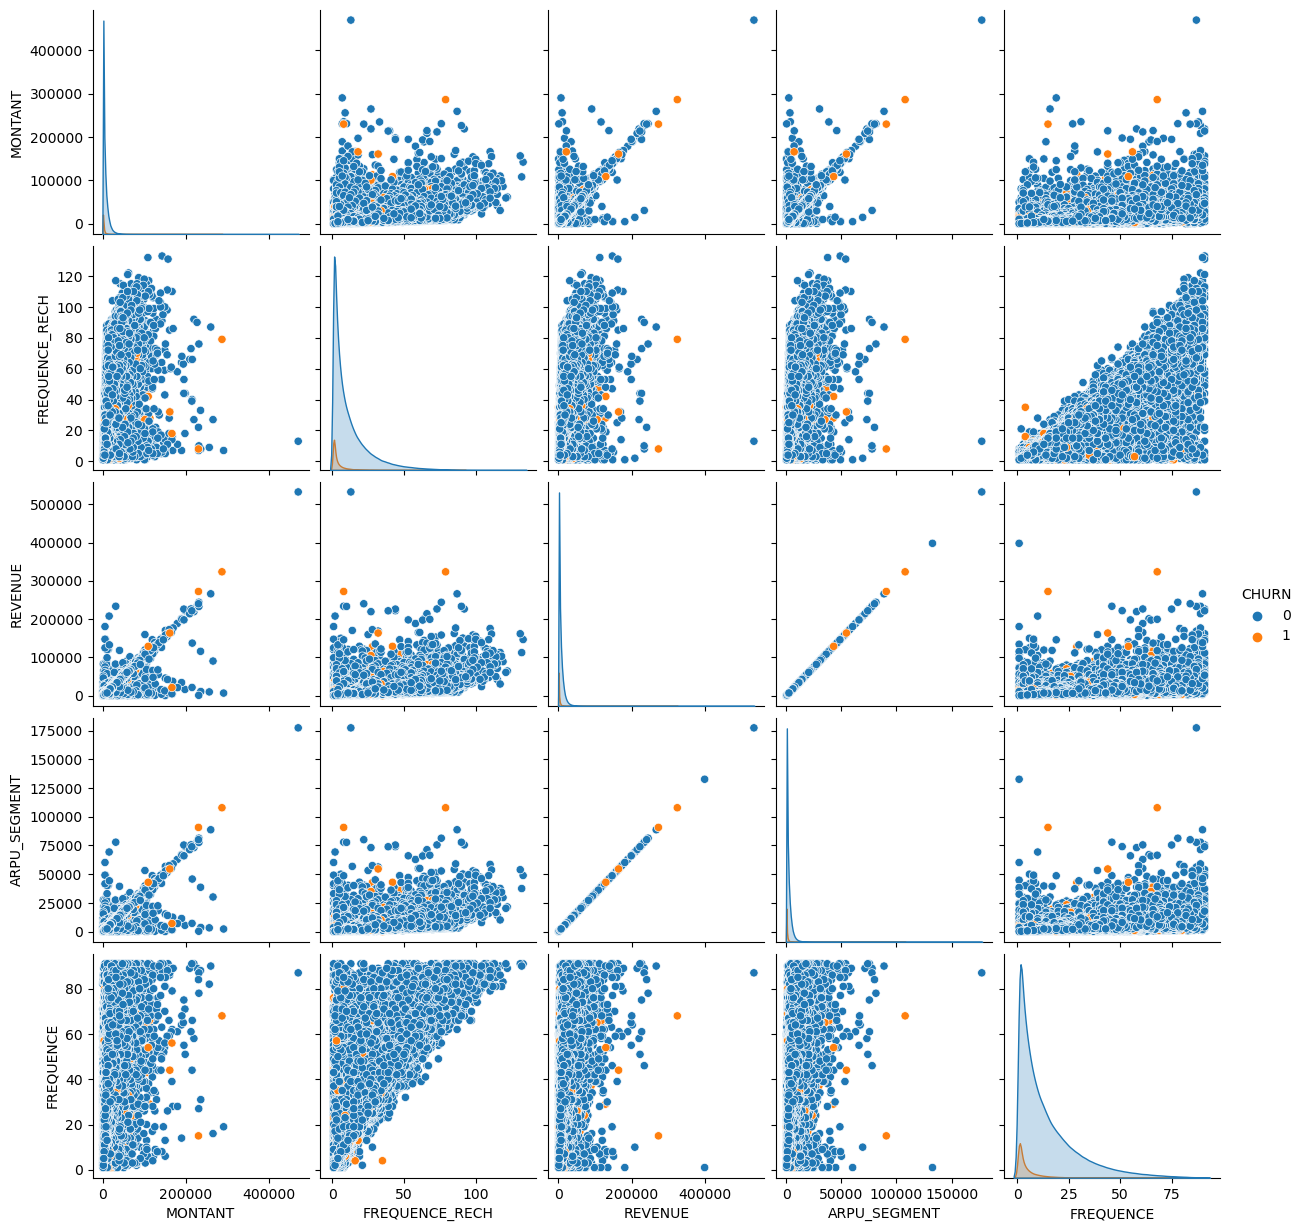

In [14]:
sns.pairplot(data=df[['MONTANT', 'FREQUENCE_RECH', 'REVENUE','ARPU_SEGMENT','FREQUENCE','CHURN']], diag_kind='kde', hue='CHURN')
plt.show()

**3.5 User Behaviors**

Fields that we consider to choose.

* DATA_VOLUME: the amount of data used by the customer
* ON_NET: inter Expresso calls made by the user
* ORANGE: calls to Orange network
* TIGO: calls to Tigo network
* ZONE1: calls to ZONE1 network
* Zone2: calls to ZONE2 network

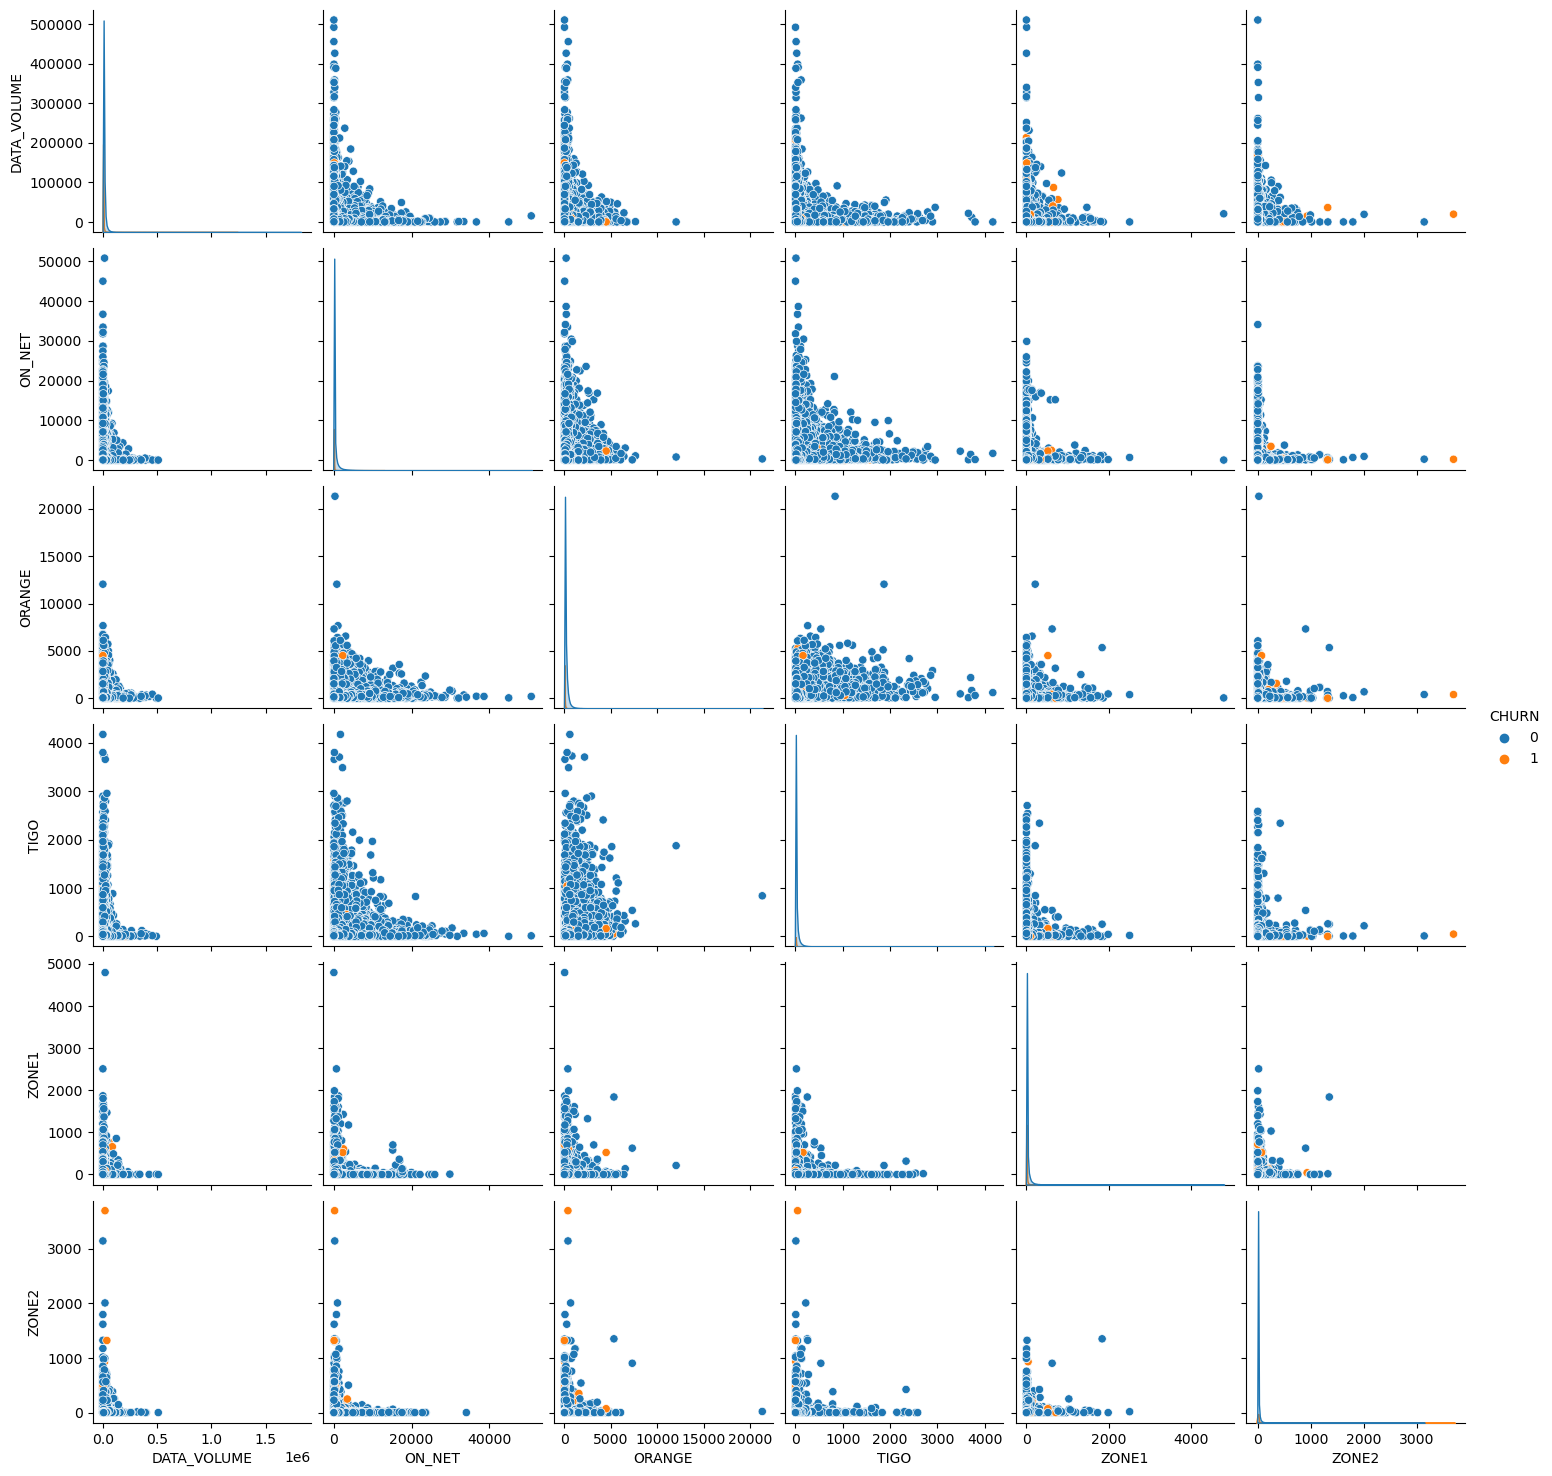

In [15]:
sns.pairplot(data=df[['DATA_VOLUME', 'ON_NET', 'ORANGE','TIGO','ZONE1', 'ZONE2', 'CHURN']], diag_kind='kde', hue='CHURN')
plt.show()

**3.6 Indicators**

* MRG: the merger status / A client who is going
* REGULARITY: number of month the customer is active for 90 days
* TOP_PACK: the most active packs
* FREQ_TOP_PACK: number of times of activating the top service package

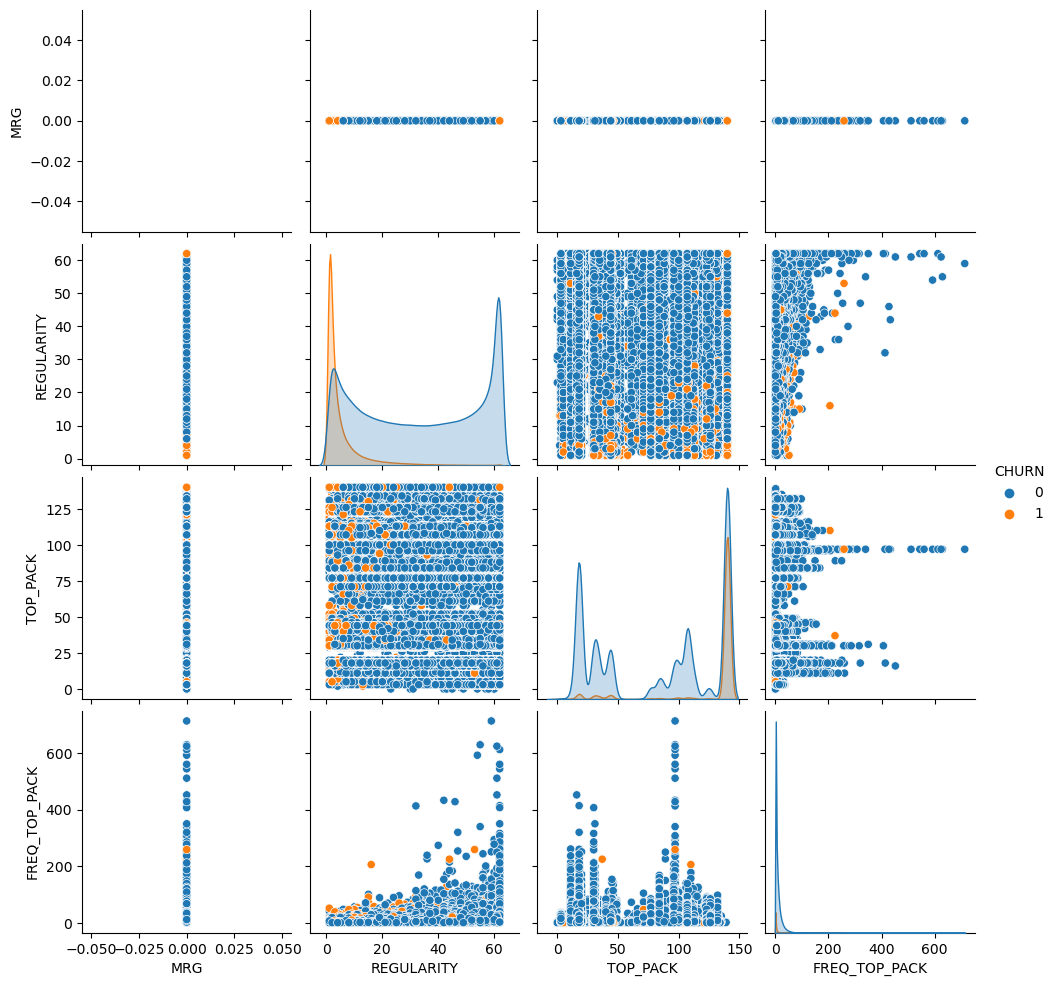

In [16]:
sns.pairplot(data=df[['MRG', 'REGULARITY', 'TOP_PACK','FREQ_TOP_PACK','CHURN']], diag_kind='kde', hue='CHURN')
plt.show()

# 4. Data Preprocessing

The logic is that we train a model, then put it into production. With the model we trained to help provent users churning. Let's continue our work for our model training. After we analized the data, next step is preprocess our data.

Usually the following aspects for data precessing & Feature Enigneering are included.
* Handling missing values
* Handling outliers
* Binning numeric variables
* Encoding categorical features
* Numerical transformations
* Scaling numerical features
* Extracting parts of a date

We are going to drop the unnecessary columns and duplicates, remove the NaN rows, and encoding categorical features.

In [17]:
def preprocess_data(df):
    for column in df.select_dtypes(include=[np.number]).columns: #replace numeric NaN with mean
        df[column].fillna(df[column].mean(), inplace=True)

    for column in df.select_dtypes(include=["object"]).columns: #replace categories with most popular values
        df[column].fillna(df[column].mode().iloc[0], inplace=True)

    # Check duplicates
    df = df.drop_duplicates()

    # Drop the 'user_id' column, if it exists
    df = df.drop(['user_id'], axis=1, errors='ignore')

    # Label encoding
    le = LabelEncoder()
    df.MRG = le.fit_transform(df.MRG)
    df.TENURE = le.fit_transform(df.TENURE)
    df.REGION = le.fit_transform(df.REGION)
    df.TOP_PACK = le.fit_transform(df.TOP_PACK)

    return df

df = preprocess_data(df)

In [18]:
# sperate variables and prediction
y = df['CHURN']
x = df.drop(['CHURN'], axis=1, errors='ignore')

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.8,random_state=1000)

# 5. Data Modeling

We are going to use the following models to find the best model and make predictions.


**5.1 Predict with LogisticRegression**

Logistic Regression: predicts probability of outcome using linear function.

We set the maximum number of iterations to 1000, scale the input data to help the optimization algorithm converge faster.

In [19]:
lr_model = LogisticRegression(max_iter=1000)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lr_model = LogisticRegression()
lr_model.fit(x_train_scaled, y_train)
y_prob_lr = lr_model.predict_proba(x_test_scaled)[:, 1]

print("ROC with Logistic Regression:", roc_auc_score(y_test, y_prob_lr))

ROC with Logistic Regression: 0.9205009326841972


**5.2 Use Decision Tree Model**

Decision Tree creates decision rules based on splitting data into subsets.

In [20]:
dc_model = DecisionTreeClassifier()
dc_model.fit(x_train,y_train)

y_prob_dc = dc_model.predict_proba(x_test)[:,1]

print("ROC with Decision Tree Model:",roc_auc_score(y_test,y_prob_dc))

ROC with Decision Tree Model: 0.8470809887818274


**5.3 Bayes Model**

Bayes estimates probability of outcome based on prior knowledge and likelihood.

In [21]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)

y_prob_nb = nb_model.predict_proba(x_test)[:,1]

print("ROC by Naive Bayes:",roc_auc_score(y_test,y_prob_nb))

ROC by Naive Bayes: 0.8998143755176281


**5.4 Use Random Forest**

Random Forest: combines many decision trees to make more accurate predictions.
This approach takes a long time than others.

In [22]:
rfr_model = RandomForestRegressor()
rfr_model.fit(x_train,y_train)

y_prob_rfr = rfr_model.predict(x_test)

print("ROC by RandomForest:",roc_auc_score(y_test,y_prob_rfr))

ROC by RandomForest: 0.9207636460473783


**5.5 Use AbaBoost**

AdaBoost combines weak models to create a strong model by iteratively adjusting weights.

In [23]:
AB_model = AdaBoostClassifier(random_state=2022)
AB_model.fit(x_train,y_train)

y_prob_AB = AB_model.predict_proba(x_test)[:,1]

print("ROC by AdaBoost:",roc_auc_score(y_test,y_prob_AB))

ROC by AdaBoost: 0.9289575083041697


**5.6 Use GradientBoosting**

GBDT builds a series of decision trees to improve upon errors of the previous trees.

In [24]:
GBDT_model = GradientBoostingClassifier(random_state=2022)
GBDT_model.fit(x_train,y_train)

y_prob_GBDT = GBDT_model.predict_proba(x_test)[:,1]

print("RUC by AdaBoost:",roc_auc_score(y_test,y_prob_GBDT))

RUC by AdaBoost: 0.9305799654854262


**5.7 Use K-NN**

K Neighbors assigns outcome based on most common outcome among k nearest neighbors.

SVM is also a good way, meanwhile it takes a longer time to train.

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

y_prob_knn = knn_model.predict_proba(x_test)[:, 1]

print("ROC by K-Nearest Neighbors:", roc_auc_score(y_test, y_prob_knn))

ROC by K-Nearest Neighbors: 0.8391633567562982


# 6. Cross Validation & Model Optimization

**6.1 Model Selection**

Display the results of all the models, choose the model with the highest performance.

In [26]:
roc_data = pd.DataFrame([['Logistic Regression', roc_auc_score(y_test, y_prob_lr)],
                         ['Decision Tree', roc_auc_score(y_test, y_prob_dc)],
                         ['Bayes', roc_auc_score(y_test, y_prob_nb)],
                         ['K Neighbors', roc_auc_score(y_test, y_prob_knn)],
                         ['Random Forest', roc_auc_score(y_test, y_prob_rfr)],
                         ['AdaBoost', roc_auc_score(y_test, y_prob_AB)],
                         ['GBDT', roc_auc_score(y_test, y_prob_GBDT)]],
                        columns=['Algorithm', 'ROC AUC Score'])

print (tabulate(roc_data, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+--------------------+
|      Algorithm      |   ROC AUC Score    |
+---------------------+--------------------+
| Logistic Regression | 0.9205009326841972 |
|    Decision Tree    | 0.8470809887818274 |
|        Bayes        | 0.8998143755176281 |
|     K Neighbors     | 0.8391633567562982 |
|    Random Forest    | 0.9207636460473783 |
|      AdaBoost       | 0.9289575083041697 |
|        GBDT         | 0.9305799654854262 |
+---------------------+--------------------+


**6.2 Model Optimization**

Use GridSearch to find the optimized parameters

In [27]:
parameters = {
    'n_estimators': range(10, 150, 10),
    'learning_rate': [0.075, 0.1, 0.15],
}

AB_model = AdaBoostClassifier()
grid_search = GridSearchCV(AB_model, parameters, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'learning_rate': 0.15, 'n_estimators': 140}

Update the best model further with updated parameters.

In [28]:
best_n_estimators = 140
best_learning_rate = 0.15

AB_model_best = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, random_state=2022)
AB_model_best.fit(x_train, y_train)
y_prob_ab_best = AB_model_best.predict_proba(x_test)[:, 1]
print("AdaBoost algorithm ROC score:", roc_auc_score(y_test, y_prob_ab_best))

AdaBoost algorithm ROC score: 0.9292083064329982


**6.3 Cross-validation**

We use k-fold cross-validation method to do this. Intially, we set k to 5, still use ROC AUC to evaludate its performance.

In [29]:
k = 5 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scores_accuracy = cross_val_score(AB_model_best, x, y, cv=kf, scoring='accuracy')
scores_roc_auc = cross_val_score(AB_model_best, x, y, cv=kf, scoring='roc_auc')

print(f'Accuracy scores for each fold: {scores_accuracy}')
print(f'Average accuracy: {scores_accuracy.mean():.4f}')
print(f'Standard deviation: {scores_accuracy.std():.4f}')
print('\n')

print(f'ROC AUC scores for each fold: {scores_roc_auc}')
print(f'Average ROC AUC: {scores_roc_auc.mean():.4f}')
print(f'Standard deviation: {scores_roc_auc.std():.4f}')


Accuracy scores for each fold: [0.87847775 0.87889789 0.87794155 0.87798073 0.87678066]
Average accuracy: 0.8780
Standard deviation: 0.0007


ROC AUC scores for each fold: [0.92914277 0.92995613 0.92885532 0.92963388 0.92829923]
Average ROC AUC: 0.9292
Standard deviation: 0.0006


The dataset is split into 5 equal-sized subsets. The model is trained and validated 5 times, each time using 4 subsets for training and one remaining subset for validation. Averaging the performance metrics from each iteration provides a more reliable performance estimate while maintaining computational efficiency. Our conclusion is that our model is not overfitting or underfitting.

**6.4 ROC_AUC Curve**

AdaBoost algorithm ROC score: 0.9292083064329982


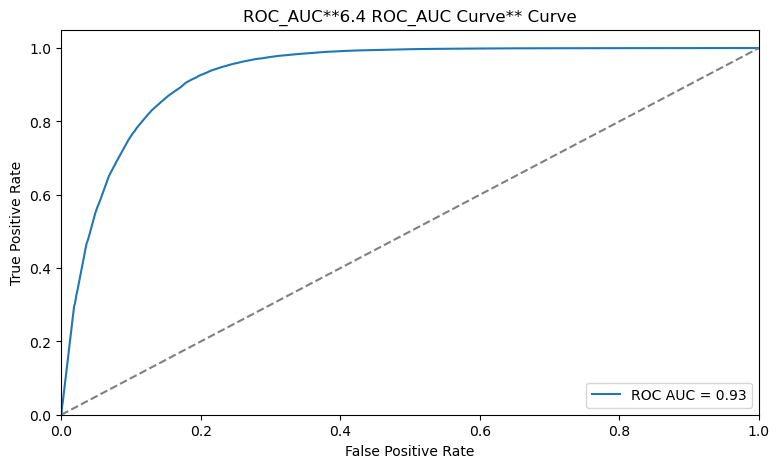

In [30]:
y_pred_ab_best = AB_model_best.predict(x_test)  # Compute the predicted class labels
print("AdaBoost algorithm ROC score:", roc_auc_score(y_test, y_prob_ab_best))

fpr, tpr, _ = roc_curve(y_test, y_prob_ab_best)
f1 = f1_score(y_test, y_pred_ab_best)

plt.figure(figsize=(9, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob_ab_best):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC Curve')
plt.legend(loc="lower right")

**6.5 Confusion Matrix**

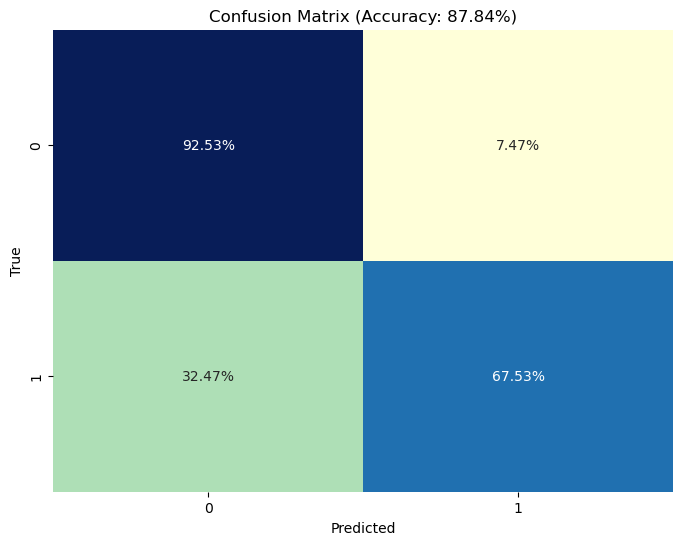

In [31]:
cm = confusion_matrix(y_test, y_pred_ab_best)

accuracy = accuracy_score(y_test, y_pred_ab_best)
percent_accuracy = accuracy * 100

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {percent_accuracy:.2f}%)')
plt.show()

**6.6 Feature Importance**

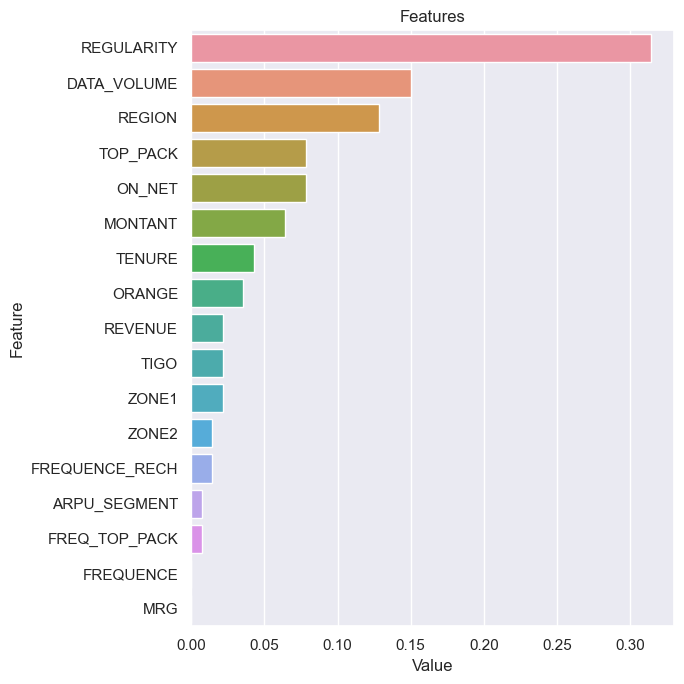

+----------------+----------------------+
|    Feature     |        Value         |
+----------------+----------------------+
|   REGULARITY   |  0.3142857142857143  |
|  DATA_VOLUME   |         0.15         |
|     REGION     | 0.12857142857142856  |
|    TOP_PACK    | 0.07857142857142857  |
|     ON_NET     | 0.07857142857142857  |
|    MONTANT     | 0.06428571428571428  |
|     TENURE     | 0.04285714285714286  |
|     ORANGE     | 0.03571428571428571  |
|    REVENUE     | 0.02142857142857143  |
|      TIGO      | 0.02142857142857143  |
|     ZONE1      | 0.02142857142857143  |
|     ZONE2      | 0.014285714285714285 |
| FREQUENCE_RECH | 0.014285714285714285 |
|  ARPU_SEGMENT  | 0.007142857142857143 |
| FREQ_TOP_PACK  | 0.007142857142857143 |
|   FREQUENCE    |         0.0          |
|      MRG       |         0.0          |
+----------------+----------------------+


In [32]:
def plot_importance(model, features, num=len(x)):
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=features.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

features = x.columns
importances = AB_model_best.feature_importances_

feat_importances = pd.DataFrame()
feat_importances['Feature'] = features
feat_importances['Value'] = importances

# Call the plot_importance function
plot_importance(AB_model_best, feat_importances)

feat_importances.sort_values('Value', ascending=False).to_excel('User_Churn_AdaBoost_Feature_Importance.xlsx')

# Print fancy table
sorted_feat_importances = feat_importances.sort_values('Value', ascending=False)
print(tabulate(sorted_feat_importances, headers='keys', tablefmt='pretty', showindex=False))


# 7. Prediction

In [33]:
#Load Test Data
test_data = pd.read_csv('/Test.csv')            #Path to Test Data File

# Save the user_id column before preprocessing
user_ids = test_data['user_id']

test_data = preprocess_data(test_data)

predictions = AB_model_best.predict(test_data)

submission = pd.DataFrame({'user_id': user_ids, 'CHURN': predictions.astype(int)})

In [34]:
churned_count = (predictions == 1).sum()
total_count = len(predictions)
churned_percentage = (churned_count / total_count) * 100

print("Churned percentage: {:.4f}%".format(churned_percentage))

test_data['CHURN'] = predictions
sorted_test_data = test_data.sort_values(by='CHURN', ascending=False)

# Display the top 10 rows
print(sorted_test_data.head(10))

Churned percentage: 0.0000%
        REGION  TENURE      MONTANT  FREQUENCE_RECH      REVENUE  \
0           12       7  5000.000000        5.000000  5000.000000   
253415       0       6  5524.958826       11.519853  5499.680468   
253424       1       7  1600.000000        4.000000  2100.000000   
253423       7       5  5524.958826       11.519853  5499.680468   
253422       0       7  3000.000000        2.000000  2372.000000   
253421       0       7   600.000000        2.000000   598.000000   
253420       9       7  1250.000000        2.000000  1250.000000   
253419       0       7  5000.000000        5.000000  4990.000000   
253418       4       7  2250.000000       10.000000  2235.000000   
253417       4       7  3750.000000        6.000000  3738.000000   

        ARPU_SEGMENT  FREQUENCE  DATA_VOLUME     ON_NET     ORANGE       TIGO  \
0        1667.000000   5.000000  3346.095454  378.00000  11.000000   5.000000   
253415   1833.232443  13.957963  3346.095454  278.80631  95.1

# 8. Conclusion

The purpose of this project is to help the company **identify which customers are at risk of churning, so that the company can take appropriate actions to retain them**. We have used ML model to flag them, which would be very helpful for the marketing team to take necessary operation actions.

After our exploratory data analysis,we got basic insights about our data. Then we preprocessed the data, tried many supervised learning approaches, such as Logistic Regression, AdaBoost, and LightGBM. We evaluated the performance of each model using the ROC AUC metric and used GridSearchCV to tune the hyperparameters for the **AbaBoost model**. Then, we used the best model to make predictions.

After training and evaluating our models, we found that the AbaBoost model had the best performance with a ROC AUC score of 0.9292. We also found that the most important features for predicting customer churn were **REGULARITY, REGION, MONTANT**, which can help the company take appropriate actions to retain customers and avoid loss of revenue.